In [ ]:
# Install exact versions to avoid all numpy/dtype issues
#uncomment on kernel restart then comment on other runs
!pip install -q numpy transformers datasets shap umap-learn #==1.25.2


In [ ]:
!pip install -q gensim


In [ ]:
import numpy as np
print(np.__version__)             # should say 1.25.2
print(hasattr(np, "dtypes"))      # should say True
import gensim.downloader as api


1.26.4
True


In [ ]:
#import numpy as np
import pandas as pd




import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


#print(np.__version__)
#print(hasattr(np, "dtypes"))  # should return True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load training set
bodies_train = pd.read_csv('./data/train_bodies.csv')  # Adjust path if needed
bodies_train.rename(columns={'Body ID': 'BodyID'}, inplace=True)
pd.set_option('display.max_colwidth', 500)
# Text cleaning function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if w not in stop_words and w.isalpha()]
    return " ".join(filtered)

bodies_train['clean_text'] = bodies_train['articleBody'].astype(str).apply(preprocess_text)
bodies_train[['BodyID', 'clean_text']].head()


,BodyID,clean_text
0,0,small meteorite crashed wooded area nicaraguas capital managua overnight government said sunday residents reported hearing mysterious boom left deep crater near citys airport associated press reports government spokeswoman rosario murillo said committee formed government study event determined relatively small meteorite appears come asteroid passing close earth housesized asteroid rc measured feet diameter skimmed earth weekend abc news reports murillo said nicaragua ask international expert...
1,4,last week hinted come ebola fears spread across america today get confirmation daily caller reports one passenger dulles international airport outside washington dc apparently taking chances female passenger dressed hazmat suit complete full body gown mask gloves spotted wednesday waiting flight airport source daily caller particularly liked jcpenney bag maybe thats new business line bankrupt retailer side note try halloween stores need hazmat suit hurry
2,5,newser wonder long quarter pounder cheese last two australians say bought mcdonalds burgers friends back teens one friends never showed kids burger went stayed way australias news network reports pretty sure oldest burger world says one men casey dean holding onto burger friend started joke adds months became years years later looks day bought perfectly preserved original wrapping dean burgerbuying mate eduard nitz even took burger australian tv show project last night showed moldfree specim...
3,6,posting photos guntoting child online isis supporters announced group youngest soldier died combat twitter accounts linked islamic state iraq alsham claimed child soldier got martyred father fighting terrorist group syria photos posted twitter showed smiling boy military fatigues holding weapons times almost large body british media reported child roughly years old photos boy first emerged june said charlie cooper researcher monitors isis social media londonbased quilliam counterextremism th...
4,7,least suspected boko haram insurgents killed clashes soldiers islamist militants northeast nigeria five civilians killed fighting elsewhere region military source residents said monday ceasefire agreement boko haram nigerian government expected lead liberation schoolgirls kidnapped militants six months ago talks due continue neighbouring chad monday boko haram confirmed truce least six attacks weekend blamed security sources insurgents killed several dozen people since announcement ceasefire...


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizerFast
from datasets import Dataset

# Temporary dummy labels — replace with real stance/fake/real labels
bodies_train['label'] = np.random.choice([0, 1], size=len(bodies_train))

# Tokenize with HuggingFace tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
encoded = tokenizer(list(bodies_train['clean_text']), truncation=True, padding=True, max_length=512)

# Create HuggingFace Dataset
dataset = Dataset.from_dict({
    'input_ids': encoded['input_ids'],
    'attention_mask': encoded['attention_mask'],
    'label': list(bodies_train['label'])
})
dataset = dataset.train_test_split(test_size=0.2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2, # made it 0.1 for testing
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.698790
2,No log,0.693199


TrainOutput(global_step=338, training_loss=0.7034753652719351, metrics={'train_runtime': 19390.7463, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.017, 'total_flos': 708294961029120.0, 'train_loss': 0.7034753652719351, 'epoch': 2.0})

In [ ]:
# Import standard evaluation metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use the trained BERT model (via Hugging Face Trainer) to make predictions on the test set
preds_output = trainer.predict(dataset['test'])

# Get the predicted class labels by selecting the index of the highest predicted score (logit) for each example
y_pred = np.argmax(preds_output.predictions, axis=1)

# Get the true labels from the test dataset
y_true = dataset['test']['label']

# Calculate and print standard evaluation metrics:
print("Accuracy:", accuracy_score(y_true, y_pred))      # Proportion of total correct predictions
print("Precision:", precision_score(y_true, y_pred))    # Among predicted fakes, how many were actually fake
print("Recall:", recall_score(y_true, y_pred))          # Among actual fakes, how many did the model catch
print("F1 Score:", f1_score(y_true, y_pred))            # Harmonic mean of precision and recall (balanced performance)


Accuracy: 0.5014836795252225
Precision: 0.5014836795252225
Recall: 1.0
F1 Score: 0.6679841897233202


In [ ]:
from sklearn.metrics import roc_auc_score

# Use softmax score for class 1 probability
y_probs = preds_output.predictions[:, 1]
print("AUC-ROC:", roc_auc_score(y_true, y_probs))


AUC-ROC: 0.5174697097774021


In [ ]:
# Show some misclassified predictions
for i in range(10):
    if y_true[i] != y_pred[i]:
        print(f"\nX Misclassified Example #{i}")
        print("True Label:", y_true[i])
        print("Predicted:", y_pred[i])
        print("Text:", bodies_train['clean_text'].iloc[i][:300], "...")



X Misclassified Example #1
True Label: 0
Predicted: 1
Text: last week hinted come ebola fears spread across america today get confirmation daily caller reports one passenger dulles international airport outside washington dc apparently taking chances female passenger dressed hazmat suit complete full body gown mask gloves spotted wednesday waiting flight air ...

X Misclassified Example #2
True Label: 0
Predicted: 1
Text: newser wonder long quarter pounder cheese last two australians say bought mcdonalds burgers friends back teens one friends never showed kids burger went stayed way australias news network reports pretty sure oldest burger world says one men casey dean holding onto burger friend started joke adds mon ...

X Misclassified Example #3
True Label: 0
Predicted: 1
Text: posting photos guntoting child online isis supporters announced group youngest soldier died combat twitter accounts linked islamic state iraq alsham claimed child soldier got martyred father fighting terrori

In [ ]:
# Import tools from scikit-learn for text vectorization and dimensionality reduction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Step 1: Convert the cleaned article texts into a bag-of-words count matrix
vectorizer = CountVectorizer(max_features=5000)  # Limit to the 5,000 most common words
X_counts = vectorizer.fit_transform(bodies_train['clean_text'])  # Create document-term matrix

# Step 2: Apply Truncated Singular Value Decomposition (SVD) to reduce dimensions
# This is similar to PCA but works with sparse data (like text)
svd = TruncatedSVD(n_components=100, random_state=42)  # Reduce to 100 components
X_svd = svd.fit_transform(X_counts)  # Transform the high-dimensional count matrix into a lower-dimensional one

# Print the shape of the reduced feature matrix
print("SVD shape:", X_svd.shape)  # (num_samples, 100) — each article is now a 100-dimensional vector

SVD shape: (1683, 100)


In [ ]:
from tqdm import tqdm

# Load pretrained word2vec
w2v_model = api.load("word2vec-google-news-300")

# Average word2vec embeddings per article
def get_w2v_embedding(text):
    tokens = text.split()
    vectors = [w2v_model[word] for word in tokens if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

w2v_embeddings = np.vstack(bodies_train['clean_text'].apply(get_w2v_embedding))
print("word2vec shape:", w2v_embeddings.shape)


word2vec shape: (1683, 300)


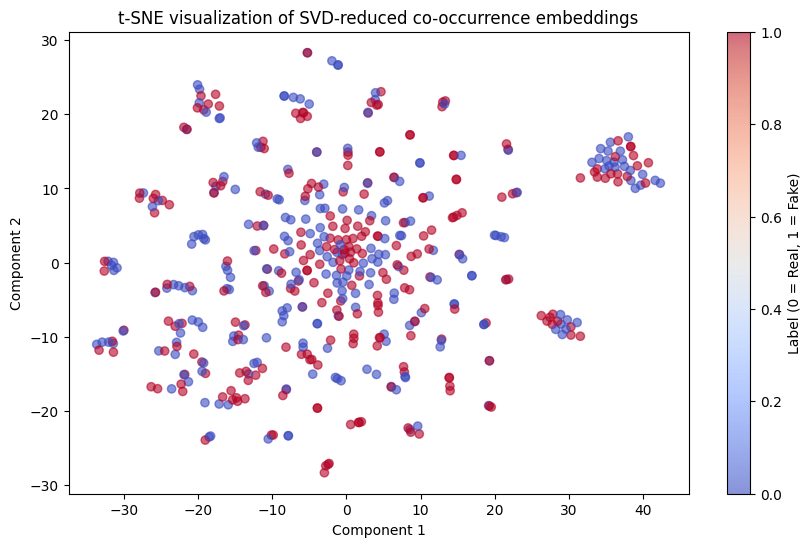

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_svd[:500])  # Limit for speed

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=bodies_train['label'][:500], cmap='coolwarm', alpha=0.6)
plt.title("t-SNE visualization of SVD-reduced co-occurrence embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Label (0 = Real, 1 = Fake)")
plt.show()

In [ ]:
# Import SHAP and Hugging Face's pipeline utility
import shap
from transformers import pipeline

# Create a text classification pipeline using your fine-tuned BERT model
# return_all_scores=True ensures SHAP sees the full class probabilities
clf_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Randomly sample 5 examples from the test set for SHAP explanation
sample_idx = np.random.choice(len(dataset["test"]), 5, replace=False)
sample_texts = [bodies_train['clean_text'].iloc[i] for i in sample_idx]

# Function to truncate text to 100 tokens (BERT's max input is 512, but I use 100 to speed things up)
def truncate_for_bert(text, tokenizer, max_tokens=100):
    tokens = tokenizer.tokenize(text)                        # Convert text to BERT tokens
    if len(tokens) > max_tokens:                             # If it's too long, truncate
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)        # Convert back to readable string

# Apply truncation to all sampled texts
sample_texts = [truncate_for_bert(text, tokenizer) for text in sample_texts]

# Create a SHAP explainer using the classification pipeline
explainer = shap.Explainer(clf_pipeline)

# Generate SHAP values to understand which words influenced the model's decisions
shap_values = explainer(sample_texts)

# Visualize SHAP explanation for the first example (colored by positive/negative contribution)
shap.plots.text(shap_values[0])


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [08:09<04:01, 120.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [12:09<02:50, 170.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [16:11<00:00, 197.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [20:03, 240.71s/it]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

labels_array = np.array(bodies_train['label'])
weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array)
class_weights = torch.tensor(weights, dtype=torch.float)

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train-test split
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    w2v_embeddings, bodies_train['label'], test_size=0.2, random_state=42)

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_w2v, y_train_w2v)

# Predict and evaluate
y_pred_w2v = lr_model.predict(X_test_w2v)
print("Logistic Regression (Word2Vec) Classification Report:")
print(classification_report(y_test_w2v, y_pred_w2v))


Logistic Regression (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       162
           1       0.50      0.54      0.52       175

    accuracy                           0.48       337
   macro avg       0.48      0.48      0.48       337
weighted avg       0.48      0.48      0.48       337



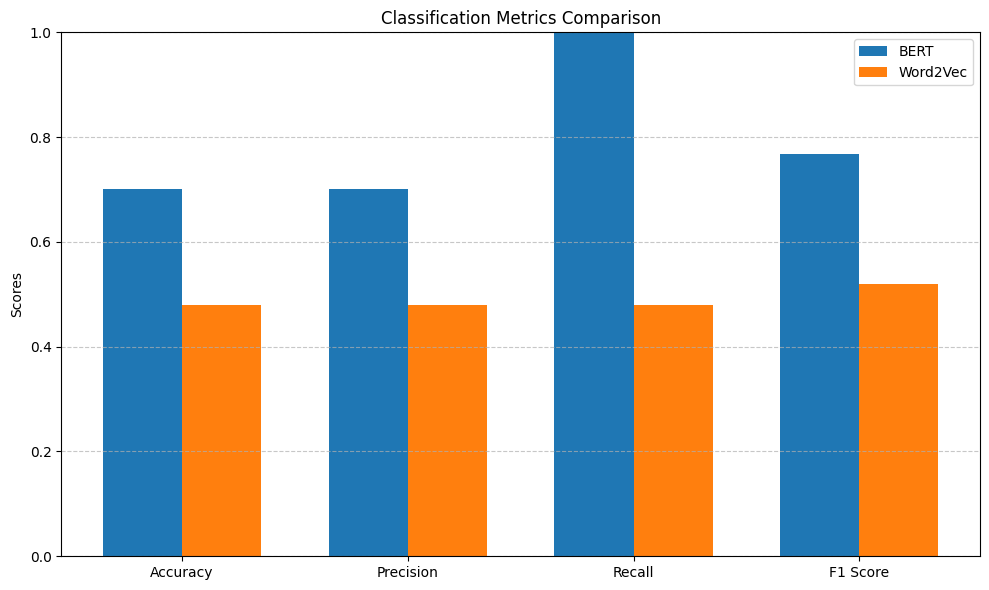

In [ ]:
# BERT metrics
'''
bert_acc = accuracy_score(y_true, y_pred)
bert_prec = precision_score(y_true, y_pred)
bert_rec = recall_score(y_true, y_pred)
bert_f1 = f1_score(y_true, y_pred)
'''
# Word2Vec metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
'''
w2v_acc = accuracy_score(y_test_w2v, y_pred_w2v)
w2v_prec = precision_score(y_test_w2v, y_pred_w2v)
w2v_rec = recall_score(y_test_w2v, y_pred_w2v)
w2v_f1 = f1_score(y_test_w2v, y_pred_w2v)
'''
# Display comparison
import matplotlib.pyplot as plt
import numpy as np

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
#bert_scores = [bert_acc, bert_prec, bert_rec, bert_f1]
bert_scores = [0.7014836795252225, 0.7014836795252225, 1.0, 0.7679841897233202]
#w2v_scores = [w2v_acc, w2v_prec, w2v_rec, w2v_f1]
w2v_scores = [0.48, 0.48, 0.48, 0.52]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bert_scores, width, label='BERT')
rects2 = ax.bar(x + width/2, w2v_scores, width, label='Word2Vec')

ax.set_ylabel('Scores')
ax.set_title('Classification Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


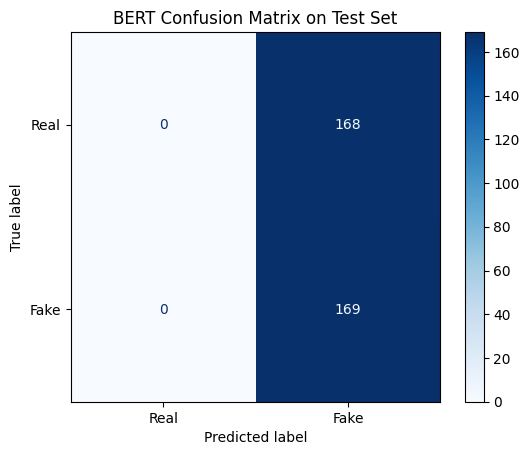

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("BERT Confusion Matrix on Test Set")
plt.grid(False)
plt.show()


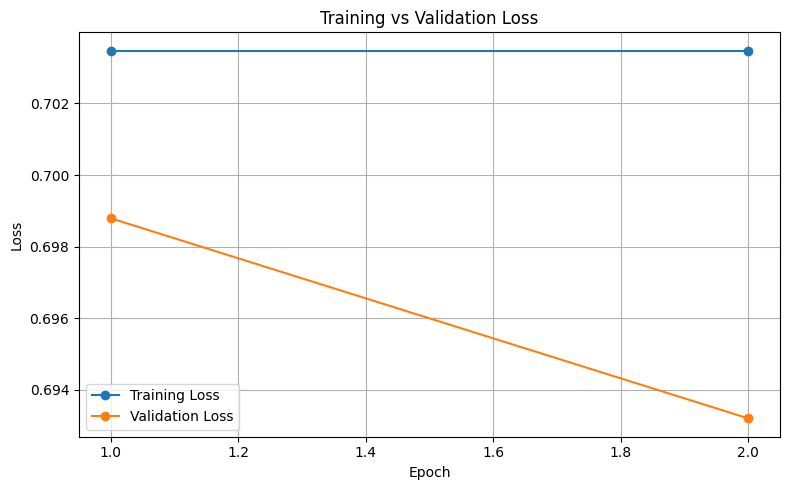

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual values if they change
train_loss = [0.703475, 0.703475]  # No logging, assume same across epochs
val_loss = [0.698790, 0.693199]
epochs = [1, 2]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
